In [34]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [303]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [262]:
#merged_des_st82_s = fitsio.read('result_cat/merged_des_st82_nocut.fits')
path = '/n/des/lee.5922/data/gold_cat/'

columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
           'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
           'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
           'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
           'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP']

from cmass_modules.Cuts import priorCut
merged_des_st82 = io.SearchAndCallFits(path = path, columns = columns, keyword = 'Y1A1_GOLD_STRIPE82_v2')
merged_des_st82 = merged_des_st82[merged_des_st82['MODEST_CLASS'] == 1]
merged_des_st82 = Cuts.keepGoodRegion(merged_des_st82)
#mask_cmass = (clean_cmass_data_des['FLAGS_GOLD'] == 0 )&(priorCut_test(clean_cmass_data_des))
mask_all = (merged_des_st82['FLAGS_GOLD'] == 0 )&(priorCut(merged_des_st82))
merged_des_st82 = merged_des_st82[mask_all]
#clean_cmass_data_des = clean_cmass_data_des[mask_cmass]
#merged_des_st82 = Cuts.SpatialCuts(merged_des_st82, ra=320, ra2=360, dec=-2, dec2=2)

Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits


In [305]:
# calling cmass
cmass = io.getSGCCMASSphotoObjcat()
#cmass = Cuts.SpatialCuts(cmass, ra=320, ra2=360, dec=-2, dec2=2)
print 'num of cmass in sgc region', cmass.size
cmass = Cuts.keepGoodRegion(cmass)
print 'num of cmass after des veto', cmass.size

Applying Healpix BOSS SGC footprint mask
Change healpix mask to spatial cut later..... Don't forget!!! 
num of cmass in sgc region 246982
num of cmass after des veto 11933


In [6]:
# caught by gold
m1, m2, d = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], merged_des_st82['RA'], \
                                     merged_des_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(merged_des_st82.size, dtype=bool)
cmass_mask[m2] = 1
clean_cmass_data_des, nocmass = merged_des_st82[cmass_mask], merged_des_st82[~cmass_mask]
print 'num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size * 100)

num of cmass in des side 11552 (97%)


In [17]:
des_spt = io.SearchAndCallFits(path = path, keyword = 'Y1A1_GOLD_0000')
des_spt = des_spt[des_spt['MODEST_CLASS'] == 1]
des_spt = Cuts.keepGoodRegion(des_spt)
des_spt = des_spt[des_spt['DEC'] < -3]
mask_y1a1 = (des_spt['FLAGS_GOLD'] == 0 )&(priorCut(des_spt))
des_spt = des_spt[mask_y1a1]

Y1A1_GOLD_000002.fits
Y1A1_GOLD_000003.fits
Y1A1_GOLD_000005.fits
Y1A1_GOLD_000007.fits
Y1A1_GOLD_000009.fits
Y1A1_GOLD_000011.fits
Y1A1_GOLD_000013.fits
Y1A1_GOLD_000015.fits
Y1A1_GOLD_000001.fits
Y1A1_GOLD_000004.fits
Y1A1_GOLD_000006.fits
Y1A1_GOLD_000008.fits
Y1A1_GOLD_000010.fits
Y1A1_GOLD_000012.fits
Y1A1_GOLD_000014.fits


In [10]:
# Fitting
cmass_fraction = clean_cmass_data_des.size * 1./merged_des_st82.size
print cmass_fraction

from xd import _FindOptimalN
n_cmass, _, _ = _FindOptimalN( np.arange(2, 10, 2), clean_cmass_data_des, pickleFileName = 'pickle/optimal_n_cmass30.pkl', suffix = '')
n_no,_,_ = _FindOptimalN( np.arange(20,30, 2), nocmass, pickleFileName = 'pickle/optimal_n_no30.pkl', suffix = '')

pickleFileName = 'pickle/gold_st82_30_cut21_XD_no.pkl'                  
clf_no = XD_fitting( nocmass, pickleFileName = pickleFileName, \
                  init_params=None, suffix = '', n_cl = n_no )
#pickleFileName = 'pickle/gold_st82_28_cut21_XD_cmass_tot.pkl'
#clf_cmass = XD_fitting( clean_cmass_data_des, pickleFileName = pickleFileName,\
#                       suffix = '', n_cl = n_cmass )
pickleFileName = 'pickle/gold_st82_30_cut21_XD_cmass.pkl'
clf_cmass = XD_fitting( clean_cmass_data_des, pickleFileName = pickleFileName,\
                       suffix = '', n_cl = n_cmass )

0.016306526563
@pickle_results: using precomputed results from 'pickle/optimal_n_cmass30.pkl'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  6
@pickle_results: using precomputed results from 'pickle/optimal_n_no30.pkl'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  28
@pickle_results: using precomputed results from 'pickle/gold_st82_30_cut21_XD_no.pkl'
@pickle_results: using precomputed results from 'pickle/gold_st82_30_cut21_XD_cmass.pkl'


In [18]:
# dmass from spt
rabin = np.linspace(des_spt['RA'].min(), des_spt['RA'].max(), 15)
ind_map = np.digitize(des_spt['RA'], bins = rabin)

des_spt_list = []
for i in range(1, rabin.size):
    ts = assignCMASSProb(des_spt[ind_map == i] , clf_cmass, clf_no, cmass_fraction = cmass_fraction )
    des_spt_list.append(ts)
    ts = None
    
des_spt = np.hstack(des_spt_list)
des_spt_list = None

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing

In [430]:
des_spt2 = Cuts.keepGoodRegion(des_spt)

In [536]:
dmass_spt2, _ = resampleWithPth( des_spt2, pstart = 0, pmax = 1.0 )

In [19]:
dmass_spt, _ = resampleWithPth( des_spt, pstart = 0, pmax = 1.0 )

In [432]:
dmass_spt2.size, dmass_spt.size

(110305, 110305)

In [537]:
clean_cmass_data_des.size * 1./ST82Maparea, dmass_spt2.size * 1./SPTMaparea, clean_cmass_data_des.size * 1./ST82Maparea * (dmass_spt.size * 1./SPTMaparea)**-1 * 100

(92.496935787657861, 87.480255744181719, 105.73464263541526)

## systematic test 

In [511]:
# calling catalog
from systematics import GalaxyDensity_Systematics,loadSystematicMaps, chisquare_dof, MatchHPArea, SysMapBadRegionMask, callingEliGoldMask

kind = 'SPT'
nside = 4096

properties = ['AIRMASS', 'SKYBRITE', 'SKYSIGMA', 'FWHM', 'NSTARS']
#properties = ['FWHM']
filter = ['g', 'r', 'i', 'z']

# Calling maps
MaskDic = {}
for i,p in enumerate(properties):
    if p == 'NSTARS':
        filename =  'y1a1_gold_1.0.2_stars_nside1024.fits'
        sysMap = loadSystematicMaps( filename = filename, property = p, filter = 'g', nside = 1024 , kind = kind)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
        mapname = 'sys_'+p+'_'+'g'+'_'+kind
        MaskDic[mapname] = sysMap
    else :
        filter = ['g', 'r', 'i', 'z']
        filename = None

        for j,f in enumerate(filter):
            sysMap = loadSystematicMaps( filename = filename, property = p, filter = f, nside = nside , kind = kind)
            mapname = 'sys_'+p+'_'+f+'_'+kind
            keep = np.in1d(sysMap['PIXEL'], GoldMask['PIXEL'])
            MaskDic[mapname] = sysMap[keep]


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_AIRMASS_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_AIRMASS_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_AIRMASS_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_AIRMASS_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096

PATH =  /n/des/lee.

In [512]:
rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
rand_bg = Cuts.keepGoodRegion(rand_bg)

rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass_spt2, size = 10 * dmass_spt2.size)
rand = Cuts.keepGoodRegion(rand)

rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
rand_train = Cuts.keepGoodRegion(rand_train)

In [435]:
rand_bg.size, dmass_spt2.size

(2215435, 110305)

In [535]:
MaskDic['sys_FWHM_i_SPT']['SIGNAL'].max()

3.9999997615814209

In [547]:
kind = 'SPT'
FullArea = SPTMaparea
#def CalculteGalaxyNgal(data, ):
#properties = ['FWHM']
properties = ['AIRMASS', 'SKYBRITE', 'SKYSIGMA', 'FWHM', 'NSTARS']
# calculating galaxy density and weights iterately
from systematics import ReciprocalWeights, jksampling

for p in properties:
    if p is 'NSTARS':
        nside = 1024
        filter = ['g']
    else :
        nside = nside
        filter = ['g', 'r', 'i', 'z']
    for j,f in enumerate(filter):

        mapname = 'sys_'+p+'_'+f+'_'+kind #+'_masked'
        bins, Bdensity, Berr, Bf_area = GalaxyDensity_Systematics(dmass_spt2, MaskDic[mapname], rand = rand_bg, nside = nside,\
                                                                    property = p, filter = f, FullArea = FullArea)
        bins, Rdensity, Rerr, Rf_area = GalaxyDensity_Systematics(rand, MaskDic[mapname], rand = rand_bg, nside = nside,\
                                                                    property = p, filter = f, FullArea = FullArea)
        print Bdensity
        #bins = bins/np.sum(sysMap['SIGNAL']) *len(sysMap)
        #B_jkerr = jksampling(clean_dmass, MaskDic[mapname], property = p, nside = nside, njack = 30, raTag = 'RA', decTag = 'DEC' )
        filename = 'data_txt/systematic_'+p+'_'+f+'_'+kind+'_seeing20.txt'
        #DAT = np.column_stack(( bins-(bins[1]-bins[0])*0.1, Bdensity, Berr, Bf_area, Bdensity, Berr, Bf_area  ))
        DAT = np.column_stack(( bins, Bdensity, Berr, Bf_area, Rdensity, Rerr, Rf_area  ))
        np.savetxt(filename, DAT, delimiter = ' ', header = 'bins, Cdensity, Cerr, Cfarea, Rdensity, Rerr, Rfarea, R_jkerr')
        print "saving data to ", filename
        
    #doVisualization_ngal(property = p, nside = nside, kind = kind, suffix='')
    #angular_correlation(data = clean_dmass, rand = rand_clean, weight = [re_weights, None], suffix = '_'+kind+'_w_'+p)


[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan]
saving data to  data_txt/systematic_AIRMASS_g_SPT_seeing20.txt
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan]
saving data to  data_txt/systematic_AIRMASS_r_SPT_seeing20.txt


KeyboardInterrupt: 

In [288]:
from systematics_module.contCorrection import doVisualization_ngal

saving fig to  figure/systematic_AIRMASS_SPT_seeing.png
saving fig to  figure/systematic_SKYBRITE_SPT_seeing.png
saving fig to  figure/systematic_SKYSIGMA_SPT_seeing.png
saving fig to  figure/systematic_FWHM_SPT_seeing.png
saving fig to  figure/systematic_NSTARS_SPT_seeing.png


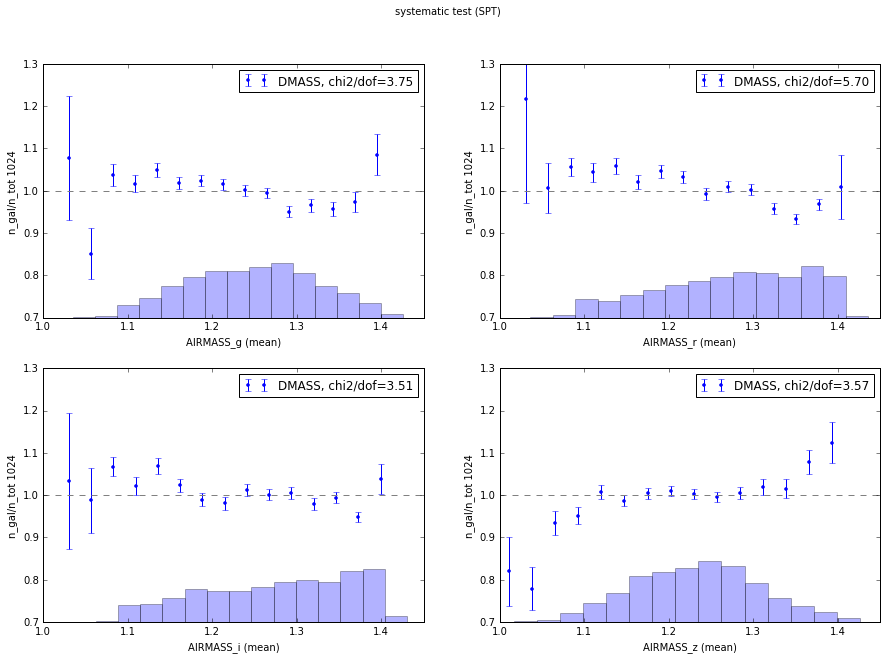

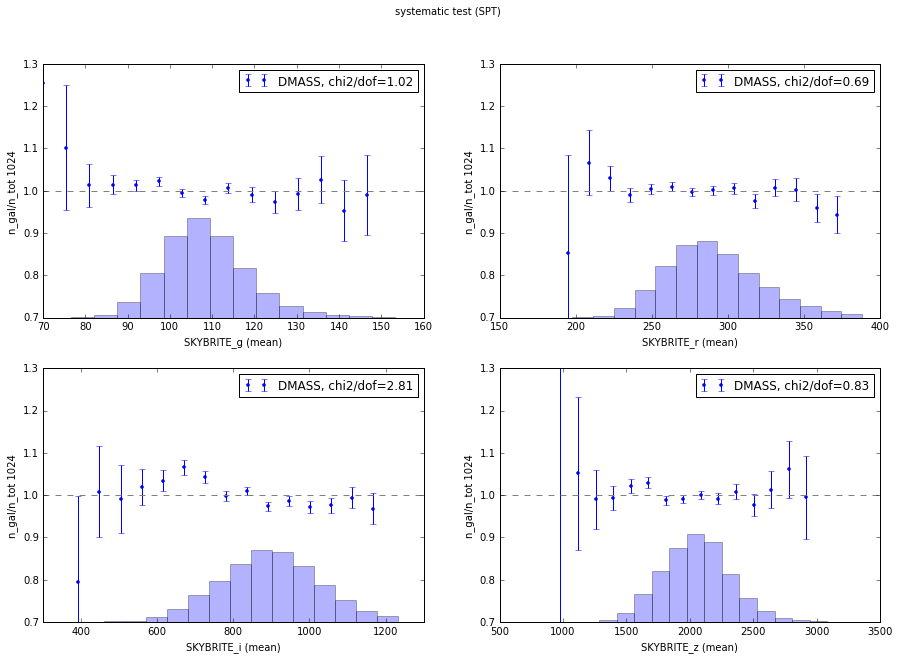

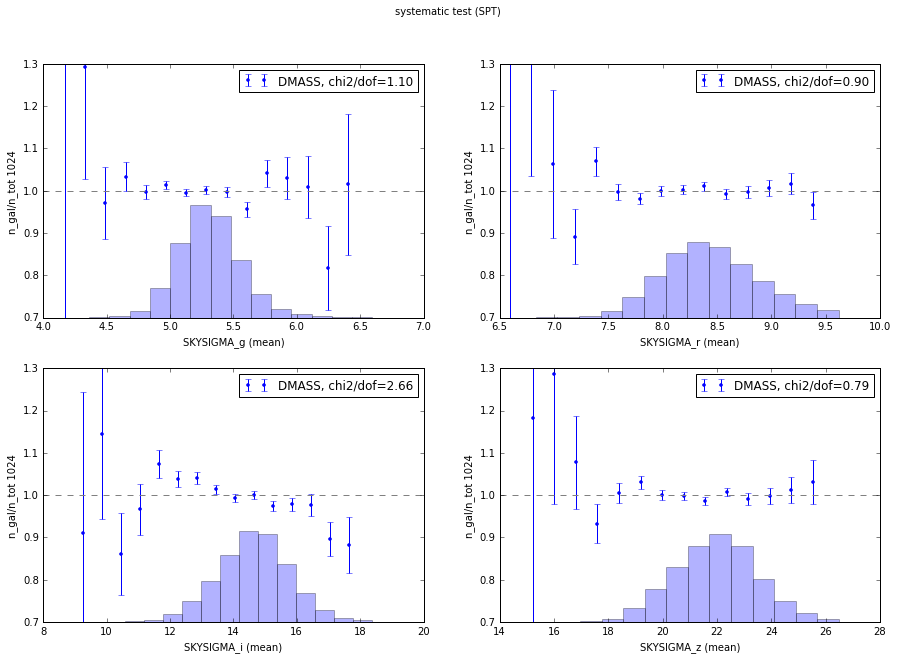

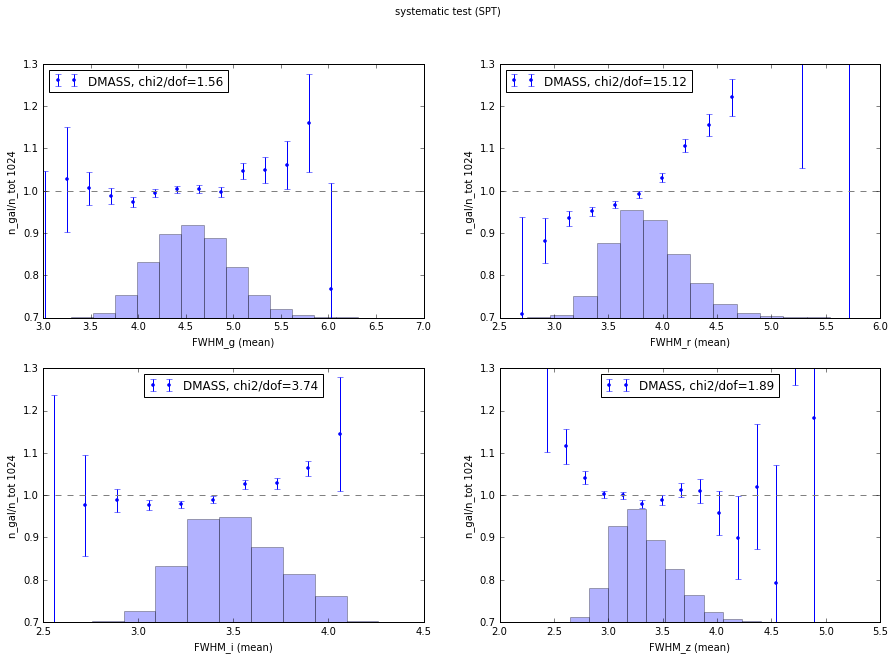

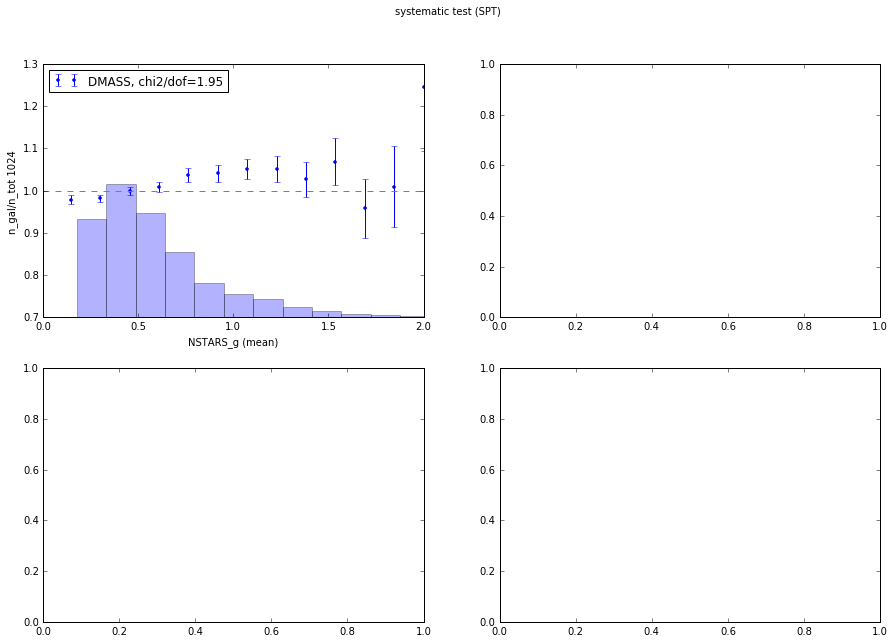

In [548]:
#properties = ['AIRMASS', 'SKYBRITE', 'SKYSIGMA', 'FWHM', 'NSTARS']
#properties = ['FWHM', 'NSTARS']
for p in properties:
    doVisualization_ngal(property = p, nside = nside, kind = 'SPT', suffix='_seeing')

saving fig to  figure/systematic_AIRMASS_STRIPE82.png
saving fig to  figure/systematic_SKYBRITE_STRIPE82.png
saving fig to  figure/systematic_FWHM_STRIPE82.png
saving fig to  figure/systematic_SKYSIGMA_STRIPE82.png
saving fig to  figure/systematic_NSTARS_STRIPE82.png


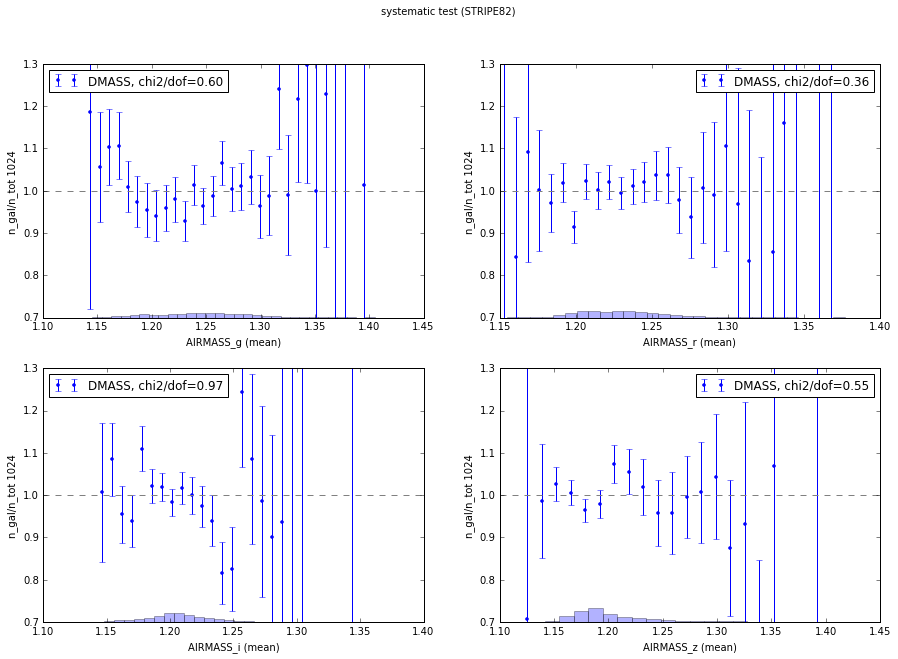

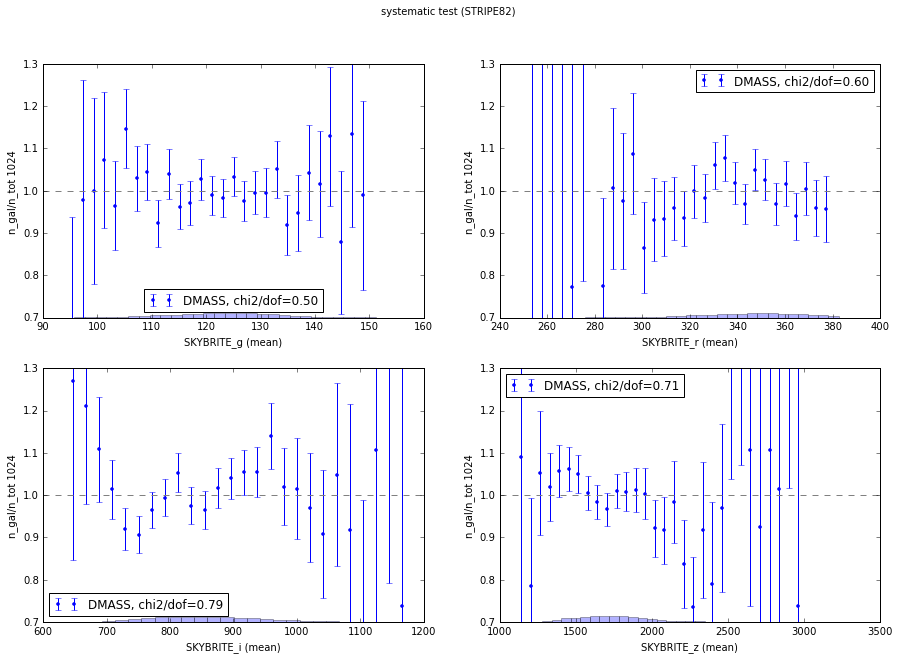

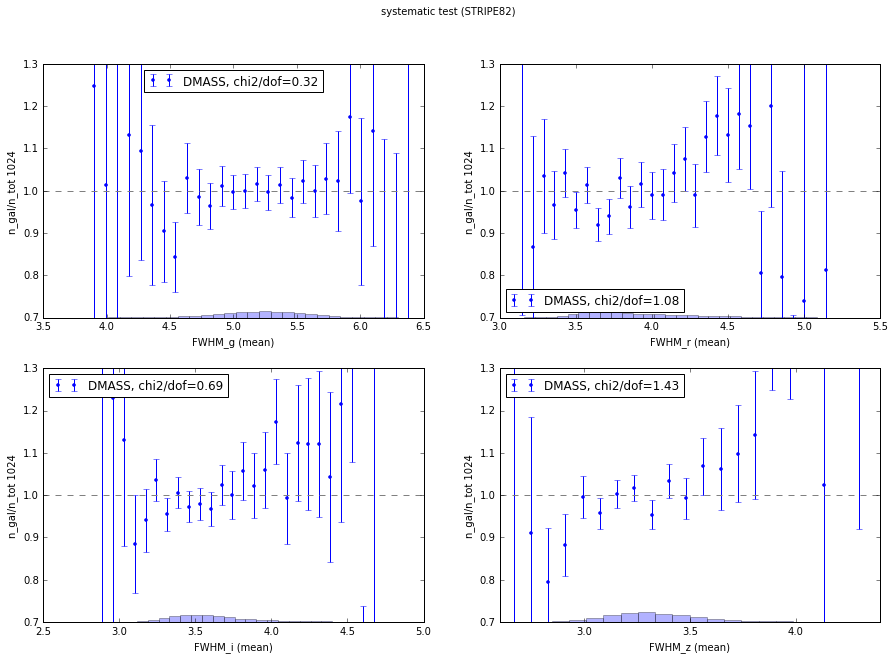

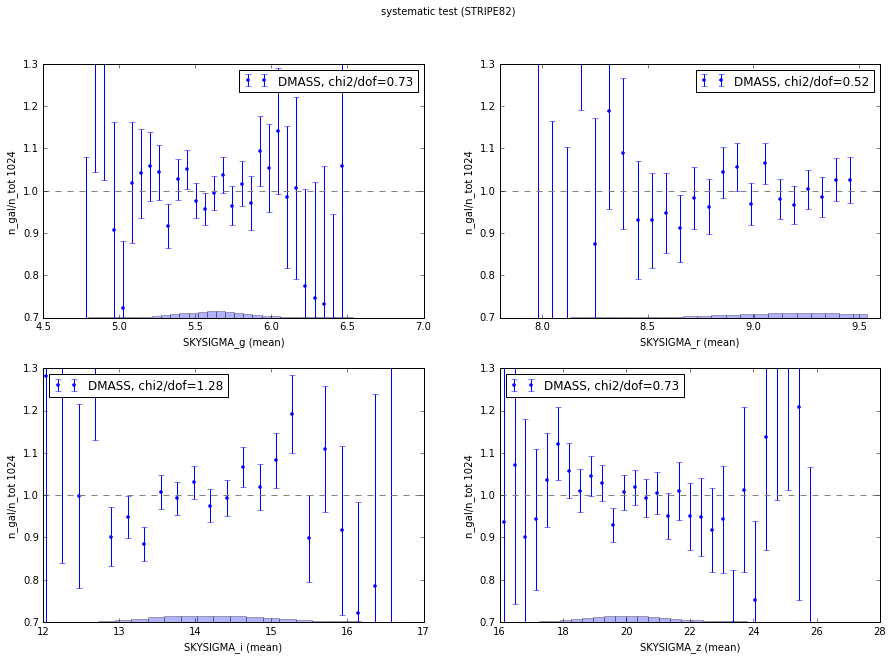

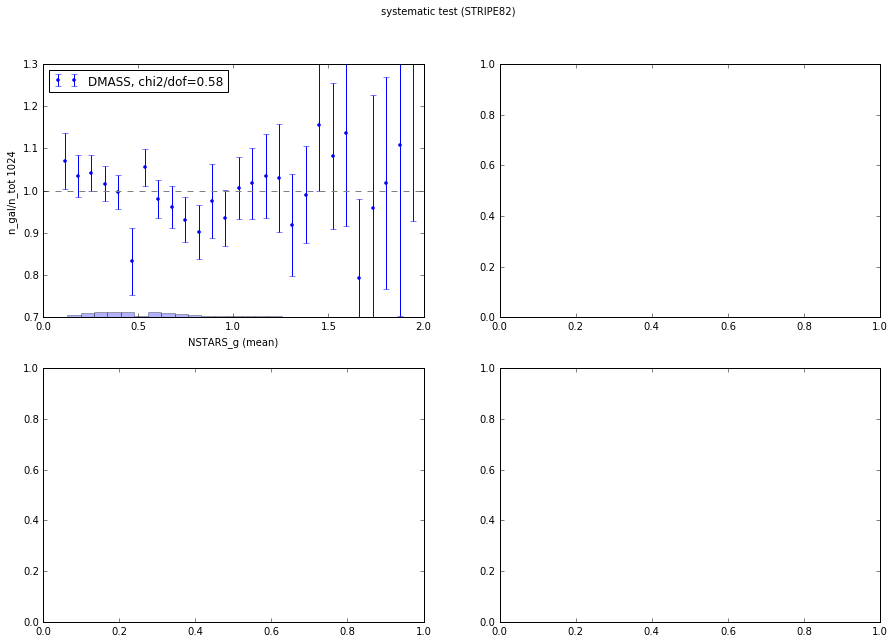

In [48]:
for p in properties:
    doVisualization_ngal(property = p, nside = 1024, kind = 'STRIPE82', suffix='')

### Fitting seeing_i

In [582]:
# call file
filename = 'data_txt/systematic_'+'FWHM'+'_'+'r'+'_'+'SPT'+'_seeing'+'.txt'
data = np.loadtxt(filename)
bins, Cdensity, Cerr, Cf_area, Rdensity, Rerr, Rf_area = [data[:,j] for j in range(data[0].size)]
zeromaskC, zeromaskR = ( Cdensity != 0.0 ) * (Cerr < 1.), (Rdensity != 0.0 ) * (Rerr < 0.3)
Cdensity, Cbins, Cerr = Cdensity[zeromaskC], bins[zeromaskC], Cerr[zeromaskC]
#C_jkerr = C_jkerr[zeromaskC]
Rdensity, Rbins, Rerr = Rdensity[zeromaskR],bins[zeromaskR],Rerr[zeromaskR]
#B_jkerr = B_jkerr[zeromaskB]

In [559]:
# interpolation
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(Cbins,Cdensity)
y_predict = slope * Cbins + intercept
w_fwhm = 1./y_predict
#sysMap = MaskDic['sys_'+'FWHM'+'_'+'i'+'_'+'SPT']

import scipy
chisq, p = scipy.stats.chisquare(Cdensity, f_exp=y_predict, ddof=Cdensity.size, axis=0)
print chisq

0.116532754595


[-0.38226943  0.66874886]
[[ 0.00385578 -0.00670138]
 [-0.00670138  0.01170214]]


<Container object of 3 artists>

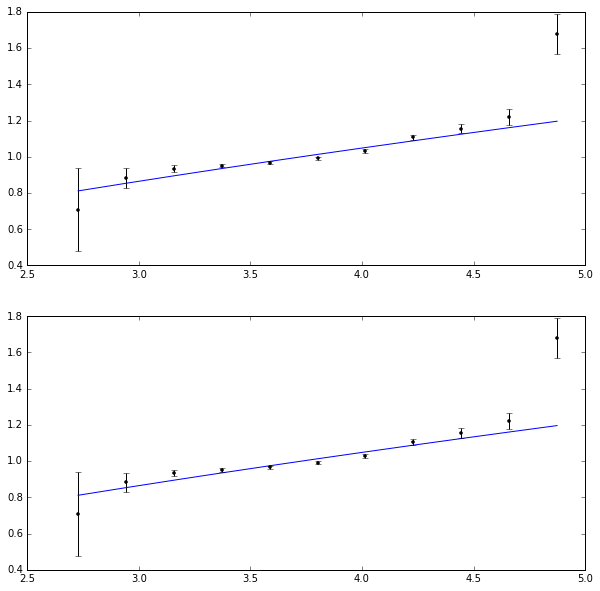

In [589]:
data_mask = Cbins < 5.0

powerlaw = lambda x, amp, index: amp * (x**index)

xdata = Cbins[data_mask]
ydata = Cdensity[data_mask]
yerr = Cerr[data_mask]

logx = np.log10(xdata)
logy = np.log10(ydata)
logyerr = yerr / ydata

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = scipy.optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print pfinal
print covar


index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[0][0] )
ampErr = np.sqrt( covar[1][1] ) * amp


fig, (ax, ax2) = plt.subplots(2,1, figsize = (10,10))
ax.plot(xdata, powerlaw(xdata, amp, index))     # Fit
ax.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data

#ax.loglog(xdata, powerlaw(xdata, amp, index))
#ax.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
ax2.plot(xdata, powerlaw(xdata, amp, index))
ax2.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
#plt.xlim(1.0, 11)

In [555]:
#Assign weights to each galaxy
catHpInd = hpRaDecToHEALPixel(dmass_spt['RA'], dmass_spt['DEC'], nside=nside, nest = False)
bin_num = Cbins.size
step = (bins[2] - bins[1])
bin_center, binned_cat, keeps = divide_bins( sysMap, Tag = 'SIGNAL', min = Cbins.min() - step/2., max = Cbins.max() + step/2., bin_num = bin_num )

wg = np.zeros( dmass_spt.size, dtype=float)
for i, sysMap_i in enumerate(binned_cat):
    HpIdxInSys_mask = np.in1d(catHpInd, sysMap_i['PIXEL'])
    wg[HpIdxInSys_mask] = w_fwhm[i]

In [581]:
Cbins[Cbins < 5.0]

array([ 2.72814703,  2.94273138,  3.15731573,  3.37190008,  3.58648443,
        3.80106878,  4.01565313,  4.23023748,  4.44482183,  4.65940619,
        4.87399054])

(0.7, 1.5)

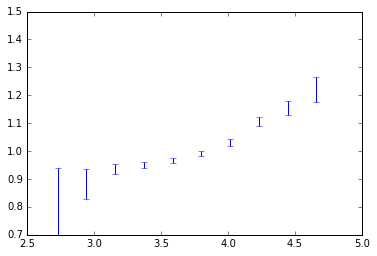

In [584]:
data_mask = Cbins < 5.0

fig, ax = plt.subplots()
ax.errorbar(Cbins[data_mask], Cdensity[data_mask], yerr = Cerr[data_mask], color ='blue', fmt='none')
#ax.errorbar(Rbins, Rdensity, yerr = Rerr, color = 'red')
#ax.plot(Cbins, y_predict, 'b--')
#ax.plot(bins, y_predict_R, 'r--')
ax.set_ylim(0.7, 1.5)


In [524]:

properties = ['FWHM']

#properties = ['NSTARS']
kind = 'SPT'
FullArea = SPTMaparea
#def CalculteGalaxyNgal(data, ):

# calculating galaxy density and weights iterately
from systematics import ReciprocalWeights, jksampling

for p in properties:
    if p is 'NSTARS':
        nside = 1024
        filter = ['g']
    else :
        nside = nside
        filter = ['g', 'r', 'i', 'z']
    for j,f in enumerate(filter):

        mapname = 'sys_'+p+'_'+f+'_'+kind #+'_masked'
        bins, Bdensity, Berr, Bf_area = GalaxyDensity_Systematics(dmass_spt2, MaskDic_fwhm[mapname], rand = rand_bg, nside = nside,\
                                                                    property = p, filter = f, FullArea = FullArea, reweight = wg)
        bins, Rdensity, Rerr, Rf_area = GalaxyDensity_Systematics(rand, MaskDic_fwhm[mapname], rand = rand_bg, nside = nside,\
                                                                    property = p, filter = f, FullArea = FullArea)
        #B_jkerr = jksampling(clean_dmass, MaskDic[mapname], property = p, nside = nside, njack = 30, raTag = 'RA', decTag = 'DEC' )
        filename = 'data_txt/systematic_'+p+'_'+f+'_'+kind+'_seeing'+'.txt'
        DAT = np.column_stack(( bins, Bdensity, Berr, Bf_area, Rdensity, Rerr, Rf_area  ))
        np.savetxt(filename, DAT, delimiter = ' ', header = 'bins, Cdensity, Cerr, Cfarea, Rdensity, Rerr, Rfarea, R_jkerr')
        print "saving data to ", filename

KeyboardInterrupt: 

saving fig to  figure/systematic_FWHM_SPT_seeing.png


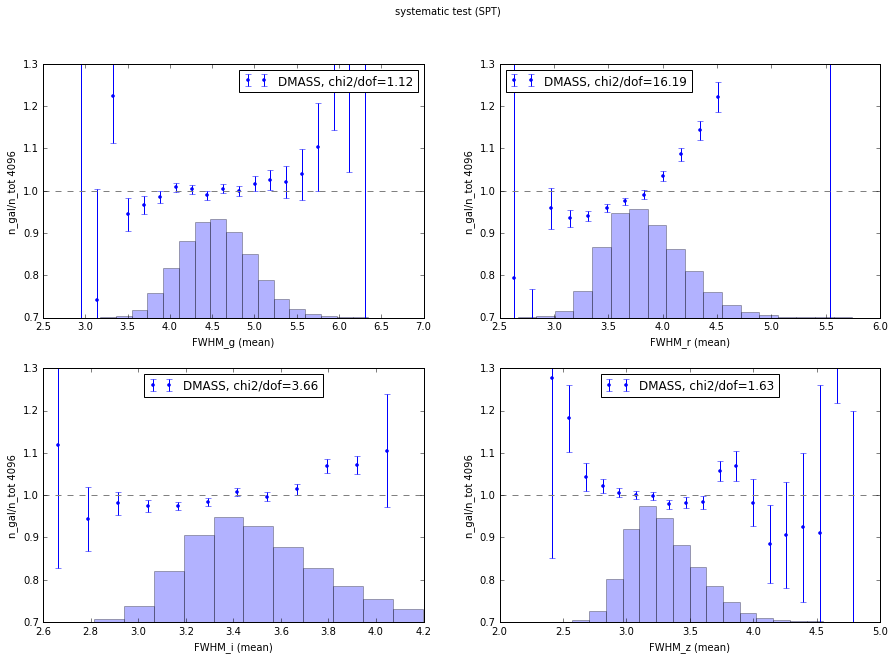

In [508]:
#properties = ['AIRMASS', 'SKYBRITE', 'FWHM', 'SKYSIGMA', 'NSTARS']
for p in properties:
    doVisualization_ngal(property = p, nside = 4096, kind = 'SPT', suffix='_seeing')

In [525]:
# calling catalog
from systematics import GalaxyDensity_Systematics,loadSystematicMaps, chisquare_dof, MatchHPArea, SysMapBadRegionMask, callingEliGoldMask

kind = 'SPT'
nside = 4096

properties = ['FWHM']
#properties = ['SKYBRITE']
filter = ['g', 'r', 'i', 'z']

# Calling maps
MaskDic_fwhm = {}
for i,p in enumerate(properties):
    if p == 'NSTARS':
        filename =  'y1a1_gold_1.0.2_stars_nside1024.fits'
        sysMap = loadSystematicMaps( filename = filename, property = p, filter = 'g', nside = 1024 , kind = kind)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
        mapname = 'sys_'+p+'_'+'g'+'_'+kind
        MaskDic_fwhm[mapname] = sysMap
    else :
        filter = ['g', 'r', 'i', 'z']
        filename = None

        for j,f in enumerate(filter):
            sysMap = loadSystematicMaps( filename = filename, property = p, filter = f, nside = nside , kind = kind)
            mapname = 'sys_'+p+'_'+f+'_'+kind
            MaskDic_fwhm[mapname] = sysMap


PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096


In [218]:
sysMap = loadSystematicMaps( property = 'FWHM', filter = 'i', nside = 4096 , kind = 'SPT', \
                                       path = '/n/des/lee.5922/data/systematic_maps/seeing_i_spt/')

Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
downgrade  4096


In [279]:
path = '/n/des/lee.5922/data/systematic_maps/'
fitsio.write(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits', LSSGoldMask2, clobber=True)

In [421]:
path = '/n/des/lee.5922/data/systematic_maps/'
#LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
#LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
#LSSGoldmask = np.loadtxt(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.dat')

In [416]:
sysMap = loadSystematicMaps( filename = None, property = 'FWHM', filter = 'i', nside = 4096 , kind = 'SPT', \
                                       path = '/n/des/lee.5922/data/systematic_maps/seeing_i_spt/')

Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT


In [406]:
path ='/n/des/lee.5922/data/systematic_maps/seeing_i_spt/'
filename = 'Y1A1NEW_COADD_SPT_band_i_FWHM/Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz'
#filename = 'Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_coaddweights3_mean.fits.gz'
sysMap_hp = hp.read_map( path+filename, nest=False)
#sysMap_ud = hp.ud_grade(sysMap_hp, nside_out = 4096 )

goodmask = hp.mask_good(sysMap_hp)
maskIndices = np.arange(sysMap_hp.size)
goodIndices = maskIndices[goodmask]
clean_map = sysMap_hp[goodmask]

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT


In [422]:
keep = np.in1d(sysMap['PIXEL'], LSSGoldmask['PIXEL'])
sysMap['SIGNAL'][keep].max()

3.9999997615814209